In [13]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer

import os
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd
import cv2
import numpy as np

from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from random import randint
from tqdm import tqdm_notebook as tqdm

import pandas as pd
import numpy as np
import glob
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import os,shutil
from keras import models,layers,optimizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam, SGD
from keras import metrics

import numpy as np                          # linear algebra
import os                                   # used for loading the data
from sklearn.metrics import confusion_matrix# confusion matrix to carry out error analysis
import seaborn as sn                        # heatmap
from sklearn.utils import shuffle           # shuffle the data
import matplotlib.pyplot as plt             # 2D plotting library
import cv2                                  # image processing library
import tensorflow as tf                     # best library ever

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'


In [15]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [16]:
def get_images():
    # read train, test images
    # make it imbalance
    # then merge, shuffle, split
    
    dir_train = './data/seg_train'
    dir_test = './data/seg_test'
    
    label_str_to_int = {
        'buildings': 0,
        'forest': 1,
        'glacier': 2,
        'mountain': 3,
        'sea': 4,
        'street': 5,
    }
    
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    
    # read train images
    for label_str in tqdm(os.listdir(dir_train), desc='dir', leave=False):
        label_int = label_str_to_int[label_str]
        image_dir = os.path.join(dir_train, label_str)
        
        for image_file in tqdm(os.listdir(image_dir), desc='images', leave=False):
            image = cv2.imread(os.path.join(image_dir, image_file)) # Read image.
            image = cv2.resize(image, (150, 150)) # Resize images. Some images are different sizes.
            train_images.append(image)
            train_labels.append(label_int)
        
    # read test images
    for label_str in tqdm(os.listdir(dir_test), desc='dir', leave=False):
        label_int = label_str_to_int[label_str]
        image_dir = os.path.join(dir_test, label_str)
        
        for image_file in tqdm(os.listdir(image_dir), desc='images', leave=False):
            image = cv2.imread(os.path.join(image_dir, image_file)) # Read image.
            image = cv2.resize(image, (150, 150)) # Resize images. Some images are different sizes.
            test_images.append(image)
            test_labels.append(label_int)
                          
                
    x_train, y_train = shuffle(train_images, train_labels)
    x_test, y_test = shuffle(test_images, test_labels)
    
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)



In [17]:
x_train, y_train, x_test, y_test = get_images()

In [18]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(10793, 150, 150, 3) (10793,)
(3604, 150, 150, 3) (3604,)


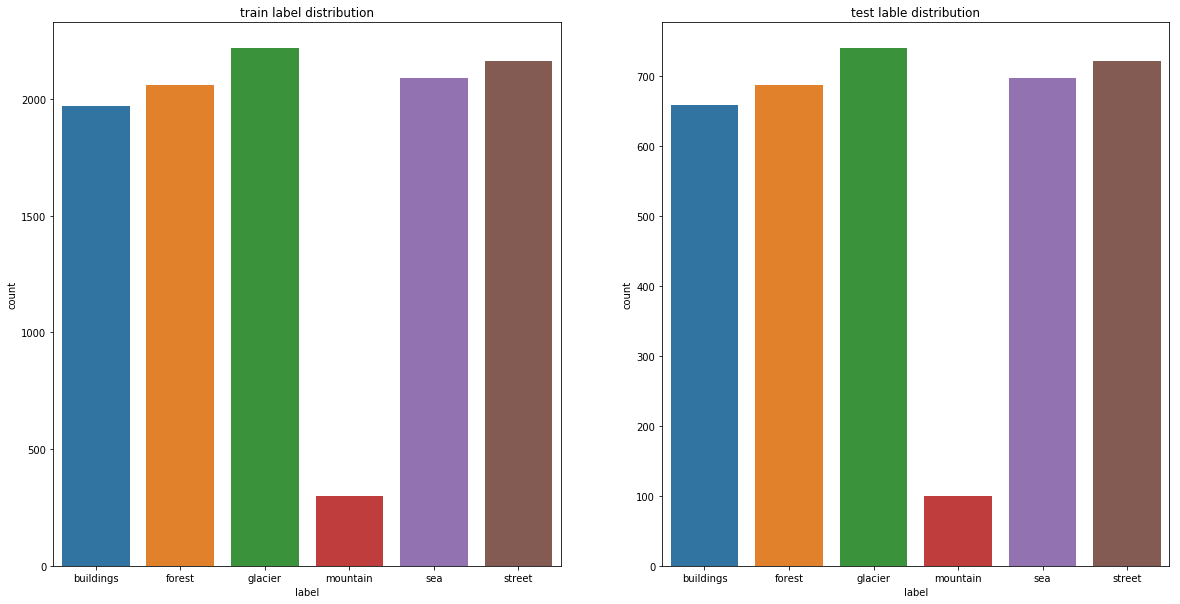

In [19]:
# label distribution
train_label_str = [get_classlabel(label_int) for label_int in y_train.tolist()]
test_label_str = [get_classlabel(label_int) for label_int in y_test.tolist()]
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

df_train_label = pd.DataFrame(train_label_str, columns=['label'])
df_test_label = pd.DataFrame(test_label_str, columns=['label'])
f, ax = plot.subplots(1, 2, figsize=(20, 10))
sns.countplot(x='label', data=df_train_label, ax=ax[0], order=labels)
ax[0].set_title('train label distribution')
sns.countplot(x='label', data=df_test_label, ax=ax[1], order=labels)
ax[1].set_title('test lable distribution')
plot.show()


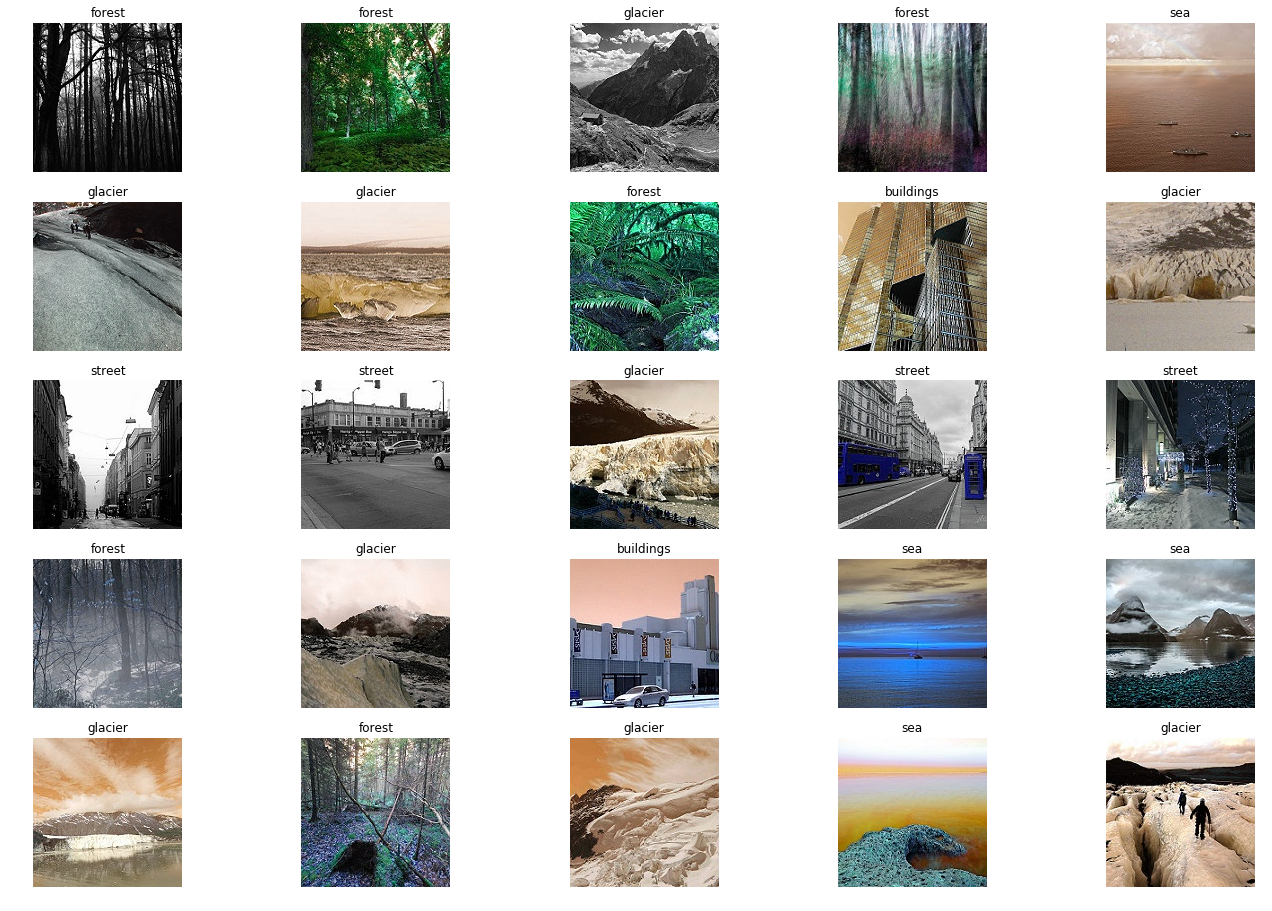

In [20]:
# some images
f, ax = plot.subplots(5, 5) 
f.subplots_adjust(0, 0, 3, 3)
for i in range(0, 5, 1):
    for j in range(0, 5, 1):
        rnd_number = randint(0, x_train.shape[0])
        ax[i, j].imshow(x_train[rnd_number])
        ax[i, j].set_title(get_classlabel(y_train[rnd_number]))
        ax[i, j].axis('off')

In [21]:

from keras.applications.resnet50 import ResNet50
res_conv = ResNet50(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    input_shape=(150,150,3),
                    pooling=None,classes=1000)
model = models.Sequential()
model.add(res_conv)

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(150,150,3), activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()
model.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(lr=1e-4),metrics=['acc'])
'''

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # the nn will learn the good filter to use
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])
'''
'''
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])'''

/home/ds4user4/.local/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          589856    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)         

/home/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,..., activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/home/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/home/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/home/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  app.launch_new_instance()
/home/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Upda

In [36]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split = 0.3)

Train on 7555 samples, validate on 3238 samples
Epoch 1/10
7555/7555 [==============================] - 47s 6ms/step - loss: 0.1331 - accuracy: 0.9568 - val_loss: 0.7922 - val_accuracy: 0.7607
Epoch 2/10
7555/7555 [==============================] - 47s 6ms/step - loss: 0.6480 - accuracy: 0.8062 - val_loss: 2.4808 - val_accuracy: 0.3867
Epoch 3/10
7555/7555 [==============================] - 47s 6ms/step - loss: 0.3729 - accuracy: 0.8908 - val_loss: 4.0970 - val_accuracy: 0.3360
Epoch 4/10
7555/7555 [==============================] - 47s 6ms/step - loss: 0.4700 - accuracy: 0.8569 - val_loss: 1.4030 - val_accuracy: 0.5920
Epoch 5/10
7555/7555 [==============================] - 47s 6ms/step - loss: 0.3521 - accuracy: 0.8826 - val_loss: 0.6539 - val_accuracy: 0.8027
Epoch 6/10
7555/7555 [==============================] - 47s 6ms/step - loss: 0.5354 - accuracy: 0.8326 - val_loss: 1.8728 - val_accuracy: 0.5293
Epoch 7/10
7555/7555 [==============================] - 47s 6ms/step - loss: 0.306

In [37]:
test_loss = model.evaluate(x_test, y_test)

3604/3604 [==============================] - 7s 2ms/step


In [38]:
test_loss

[0.464451068447909, 0.8604328632354736]